In [ ]:
!pip install -U gdown

In [ ]:
import gdown

file_id = "1DkZyM5--du7ToSeyZfPkxIezfAjg6iiw"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="cleaned_data.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1DkZyM5--du7ToSeyZfPkxIezfAjg6iiw
From (redirected): https://drive.google.com/uc?id=1DkZyM5--du7ToSeyZfPkxIezfAjg6iiw&confirm=t&uuid=f95395a1-6a7e-4e41-9595-dd84e176047c
To: /content/cleaned_data.zip
100%|██████████| 4.52G/4.52G [01:03<00:00, 70.8MB/s]


'cleaned_data.zip'

In [ ]:
import zipfile

with zipfile.ZipFile("cleaned_data.zip", 'r') as zip_ref:
    zip_ref.extractall("unzipped_data")

In [ ]:
import os

# List folders inside unzipped_data
for folder in os.listdir("unzipped_data"):
    print(folder)

cleaned_data


In [ ]:
import os
print(os.listdir("unzipped_data/cleaned_data"))

['Cairo_International_Stadium', 'Hanging_Church_(Cairo)', 'Gezira_Center_for_Modern_Art', 'Pyramid_of_Teti', 'Ben_Ezra_Synagogue', 'Temple_of_Khonsu_in_Karnak', 'Giza_pyramid_complex', 'Umm_Kulthum_Museum', 'Umm_el-Qaab', 'Wadi_Degla', 'Bab_Zuwayla', 'Pyramid_of_Amenemhat_III_in_Hawara', 'Temple_of_Isis_in_Philae', 'Al-Jawhara_Palace_museum', 'Pyramid_of_Userkaf', '45_Hapi_The_Scribe', 'amenhotep iii and tiye', '48_Stela_of_King_Qaa', 'Ras_el-Tin_Palace', 'Abu_Ghurab', "Na'ama_Bay", 'Lake_Timsah', 'Sehel_Island', 'Esna_Temple', 'Saint_George_Church_in_Coptic_Cairo', 'Great Hypostyle Hall of Karnak', 'Abu_el-Abbas_el-Mursi_Mosque', 'Tomb_of_Unknown_Soldier_in_Cairo', 'Al-Fath_Mosque', 'Monastery_of_Saint_Bishoy', '25_Mahalawi_water_ewers', 'Syrian_Monastery', 'Cairo_Citadel', 'Hurghada_Grand_Aquarium', 'Dendera_Temple_complex', '10_The_HolyQuran', 'Green_Island_(Egypt)', 'Statue of Tutankhamun with Ankhesenamun', 'Elephantine', 'Emir_Qurqumas_complex', 'Al-Nur_Mosque', 'Mortuary_Temple_

In [ ]:
import os
import random
import shutil
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# الإعدادات
dataset_path = "unzipped_data/cleaned_data"  # ✅ المسار الجديد في Colab
target_size = (224, 224)  # حجم الصورة المطلوب
min_resolution = (100, 100)  # أقل حجم مقبول للصورة
min_images = 100
max_images = 150
min_threshold = 10

# Augmentation pipeline
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(target_size[0], scale=(0.8, 1.0))
])

# دالة توليد صورة معدلة (Augmented)
def augment_image(image_path, save_path, index):
    image = Image.open(image_path).convert("RGB")
    augmented = augmentation(image)
    augmented = augmented.resize(target_size)
    augmented.save(f"{save_path}/aug_{index}.jpg")

# المعالجة الشاملة لكل كلاس
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(class_path):
        continue

    # 1. تنظيف الصور من المقاسات الغريبة وتصغيرها
    valid_images = []
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            w, h = img.size
            if w < min_resolution[0] or h < min_resolution[1]:
                os.remove(img_path)
                continue
            img = img.resize(target_size)
            img.save(img_path)
            valid_images.append(img_name)
        except:
            if os.path.exists(img_path):
                os.remove(img_path)

    # تحديث عدد الصور بعد التنظيف
    image_count = len(valid_images)

    # 2. حذف الكلاسات الضعيفة جدًا
    if image_count < min_threshold:
        shutil.rmtree(class_path)
        print(f"🗑️ Removed class '{class_name}' (less than {min_threshold} images)")
        continue

    # 3. تقليل عدد الصور في الكلاسات الكبيرة
    elif image_count > max_images:
        images_to_remove = image_count - max_images
        images_to_delete = random.sample(valid_images, images_to_remove)
        for img in images_to_delete:
            os.remove(os.path.join(class_path, img))
        print(f"📉 Reduced '{class_name}' to {max_images} images")

    # 4. توليد صور إضافية للكلاسات الصغيرة
    elif image_count < min_images:
        images_needed = min_images - image_count
        valid_images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

        # ✅ التحقق إذا كان valid_images فارغ، نتجاهل التوليد بدل ما يحصل خطأ
        if not valid_images:
            print(f"⚠️ Skipping augmentation for '{class_name}' (no valid images found)")
            continue

        for i in range(images_needed):
            img_to_augment = random.choice(valid_images)
            augment_image(os.path.join(class_path, img_to_augment), class_path, i)
        print(f"🆙 Augmented '{class_name}' to {min_images} images")

print("\n✅ كل الكلاسات تم تنظيفها وتوحيد الصور وتوازن عدد الصور بينهم.")

# بعد انتهاء المعالجة نقوم بتجميع الداتا الجديدة في متغير new_data
new_data = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        image_files = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
        if image_files:  # التأكد من أن الكلاس يحتوي على صور
            new_data[class_name] = image_files

print("\n✅ تم حفظ الداتا الجديدة في المتغير new_data")


⚠️ Skipping augmentation for '8_Senenmut' (no valid images found)
⚠️ Skipping augmentation for '7_Ra_Horakhty' (no valid images found)
⚠️ Skipping augmentation for '2_statue_ofthe_sphinx' (no valid images found)
⚠️ Skipping augmentation for '1_the_female_peasent' (no valid images found)
⚠️ Skipping augmentation for '35_The_birth_of_Isis' (no valid images found)
⚠️ Skipping augmentation for '20_TheCoffinOf_Sennedjem' (no valid images found)
⚠️ Skipping augmentation for '39_Purification_with_water' (no valid images found)
⚠️ Skipping augmentation for '15_Amun_Ra_Kingof_theGods' (no valid images found)
⚠️ Skipping augmentation for '13_theVizier_Paser' (no valid images found)
⚠️ Skipping augmentation for '12_King_Fouad_I' (no valid images found)
⚠️ Skipping augmentation for '36_King_Akhenaten' (no valid images found)
⚠️ Skipping augmentation for '37_The_Kiswa_Covering_of_holy_Kaaba' (no valid images found)
⚠️ Skipping augmentation for '23_Chair_from_the_tomb_of_Queen_Hetepheres' (no valid 

In [ ]:
# عرض أسماء المجلدات وعدد الصور من المتغير new_data
for class_name, image_files in new_data.items():
    print(f"Class: {class_name} - Number of images: {len(image_files)}")

Class: Hanging_Church_(Cairo) - Number of images: 100
Class: Ben_Ezra_Synagogue - Number of images: 100
Class: Temple_of_Khonsu_in_Karnak - Number of images: 100
Class: Giza_pyramid_complex - Number of images: 100
Class: Wadi_Degla - Number of images: 100
Class: Bab_Zuwayla - Number of images: 100
Class: Pyramid_of_Amenemhat_III_in_Hawara - Number of images: 100
Class: Temple_of_Isis_in_Philae - Number of images: 100
Class: 45_Hapi_The_Scribe - Number of images: 100
Class: amenhotep iii and tiye - Number of images: 100
Class: 48_Stela_of_King_Qaa - Number of images: 100
Class: Na'ama_Bay - Number of images: 100
Class: Esna_Temple - Number of images: 100
Class: Saint_George_Church_in_Coptic_Cairo - Number of images: 100
Class: Great Hypostyle Hall of Karnak - Number of images: 100
Class: Abu_el-Abbas_el-Mursi_Mosque - Number of images: 100
Class: Tomb_of_Unknown_Soldier_in_Cairo - Number of images: 100
Class: Monastery_of_Saint_Bishoy - Number of images: 100
Class: 25_Mahalawi_water_ewe

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence

image_paths = []
labels = []

class_names = list(new_data.keys())
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

for class_name, paths in new_data.items():
    for path in paths:
        image_paths.append(path)
        labels.append(class_to_idx[class_name])

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size=(224, 224), num_classes=10, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.image_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        X, y = self.__data_generation(batch_paths, batch_labels)
        return X, y

    def __data_generation(self, batch_paths, batch_labels):
        X = np.zeros((self.batch_size, *self.target_size, 3))
        y = np.zeros((self.batch_size, self.num_classes))

        for i, path in enumerate(batch_paths):
            img = load_img(path, target_size=self.target_size)
            img = img_to_array(img) / 255.0
            X[i] = img
            y[i] = to_categorical(batch_labels[i], num_classes=self.num_classes)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

train_gen = CustomDataGenerator(train_paths, train_labels, batch_size=32, num_classes=len(class_names))
test_gen = CustomDataGenerator(test_paths, test_labels, batch_size=32, num_classes=len(class_names), shuffle=False)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(train_gen, epochs=10, validation_data=test_gen)

loss, acc = model.evaluate(test_gen)
print(f"\n✅ دقة النموذج على بيانات الاختبار: {acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 206)            │       105,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,501,774 (169.76 MB)

 Trainable params: 44,501,774 (169.76 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2397s 5s/step - accuracy: 0.0244 - loss: 5.1570 - val_accuracy: 0.1755 - val_loss: 4.1335
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2370s 4s/step - accuracy: 0.1762 - loss: 3.9246 - val_accuracy: 0.2970 - val_loss: 3.3060
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2370s 4s/step - accuracy: 0.3258 - loss: 2.9930 - val_accuracy: 0.3792 - val_loss: 2.7057
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2385s 4s/step - accuracy: 0.4760 - loss: 2.1286 - val_accuracy: 0.4208 - val_loss: 2.5350
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2403s 5s/step - accuracy: 0.6080 - loss: 1.5411 - val_accuracy: 0.4702 - val_loss: 2.3647
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2383s 4s/step - accuracy: 0.6958 - loss: 1.1342 - val_accuracy: 0.4777 - val_loss: 2.3435
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2386s 4s/step - accuracy: 0.7566 - loss: 0.8537 - val_accuracy: 0.4861 - val_loss: 2.3981
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 2377s 4s/step - accuracy: 0.8031 - loss: 0.6928 - 

In [ ]:
model.save('first_model.h5')


# **error analysis**

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_labels[:len(y_pred)]

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


133/133 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step

📊 Classification Report:
                                                 precision    recall  f1-score   support

                         Hanging_Church_(Cairo)       0.50      0.30      0.38        20
                             Ben_Ezra_Synagogue       0.53      0.45      0.49        20
                     Temple_of_Khonsu_in_Karnak       0.33      0.20      0.25        20
                           Giza_pyramid_complex       0.29      0.20      0.24        20
                                     Wadi_Degla       0.38      0.25      0.30        20
                                    Bab_Zuwayla       0.50      0.55      0.52        20
             Pyramid_of_Amenemhat_III_in_Hawara       0.43      0.30      0.35        20
                       Temple_of_Isis_in_Philae       0.42      0.40      0.41        20
                             45_Hapi_The_Scribe       0.86      0.95      0.90        20
                         amenhotep iii an

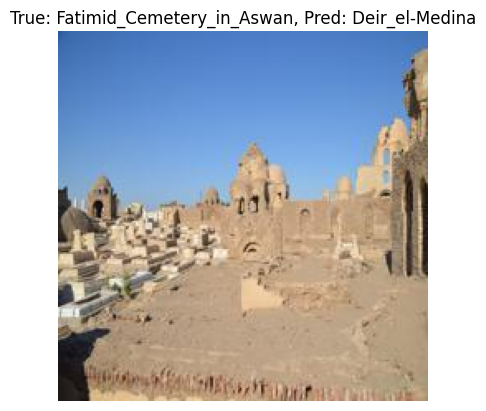

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have access to test_paths
for i in range(len(y_pred)):
    if y_pred[i] != y_true[i]:
        img = Image.open(test_paths[i])
        plt.imshow(img)
        plt.title(f"True: {class_names[y_true[i]]}, Pred: {class_names[y_pred[i]]}")
        plt.axis('off')
        plt.show()
        break


In [ ]:
for i in range(len(y_pred)):
    if y_pred[i] != y_true[i]:

      print(f"True: {class_names[y_true[i]]}, Pred: {class_names[y_pred[i]]}")

True: Fatimid_Cemetery_in_Aswan, Pred: Deir_el-Medina
True: Mosque of Al Mahmudiyah, Pred: Ramessum
True: Mohammed Ali Mosque in cairo citadel, Pred: Muhammad_Ali_Mosque
True: Nabq_Protected_Area, Pred: Babylon Fortress
True: KV62, Pred: Red_Pyramid
True: Giza_Zoo, Pred: Khan_el-Khalili
True: Monastery_of_Saint_Simeon_in_Aswan, Pred: Theban_Necropolis
True: Qubbet_el-Hawa, Pred: Bibliotheca Alexandrina
True: Great_Pyramid_of_Giza, Pred: Great Pyramids of Giza
True: Hatshepsut face, Pred: 45_Hapi_The_Scribe
True: Speos_Artemidos, Pred: Mosque_of_al-Maridani
True: Dendera_Temple_complex, Pred: Unfinished_obelisk_in_Aswan
True: Sabil_of_Abd_al-Rahman_Katkhuda, Pred: Soma_Bay
True: Wadi_el_Gemal_National_Park, Pred: Elephantine
True: Ras_Muhammad, Pred: Garden_City,_Cairo
True: Mokattam, Pred: Giza_pyramid_complex
True: Statue of Ramesses II, Pred: Ramses II Red Granite Statue
True: Red_Pyramid, Pred: Pyramid_of_Djedefra
True: Al-Ghuri_Complex, Pred: Kitchener's_Island
True: Muizz_Street, 

In [ ]:
import pandas as pd

misclassified_data = []

for i in range(len(y_pred)):
    if y_pred[i] != y_true[i]:
        misclassified_data.append({
            "Image Path": test_paths[i],
            "True Label": class_names[y_true[i]],
            "Predicted Label": class_names[y_pred[i]]
        })

misclassified_df = pd.DataFrame(misclassified_data)

print(misclassified_df.head(10))


                                          Image Path  \
0  unzipped_data/cleaned_data/Fatimid_Cemetery_in...   
1  unzipped_data/cleaned_data/Mosque of Al Mahmud...   
2  unzipped_data/cleaned_data/Mohammed Ali Mosque...   
3  unzipped_data/cleaned_data/Nabq_Protected_Area...   
4         unzipped_data/cleaned_data/KV62/aug_73.jpg   
5     unzipped_data/cleaned_data/Giza_Zoo/aug_48.jpg   
6  unzipped_data/cleaned_data/Monastery_of_Saint_...   
7  unzipped_data/cleaned_data/Qubbet_el-Hawa/aug_...   
8  unzipped_data/cleaned_data/Great_Pyramid_of_Gi...   
9  unzipped_data/cleaned_data/Hatshepsut face/40.jpg   

                             True Label          Predicted Label  
0             Fatimid_Cemetery_in_Aswan           Deir_el-Medina  
1               Mosque of Al Mahmudiyah                 Ramessum  
2  Mohammed Ali Mosque in cairo citadel      Muhammad_Ali_Mosque  
3                   Nabq_Protected_Area         Babylon Fortress  
4                                  KV62         

In [ ]:
misclassified_df["True Label"].value_counts().head(20)

,count
True Label,
Elephantine,29
Statue of Ramesses II,29
Khafre Pyramid,27
Great Pyramids of Giza,27
Siwa,23
Ramesseum,23
Colossoi of Memnon,22
Muizz_Street,20
Great_Hypostyle_Hall_of_Karnak,20


In [ ]:
misclassified_df["Predicted Label"].value_counts().head(10)

,count
Predicted Label,
Elephantine,49
Great Pyramids of Giza,48
Ramesseum,37
Al-Azhar_Park_(Cairo),34
Pyramid of Djoser,32
Statue of Ramesses II,31
Hatshepsut,30
Great_Hypostyle_Hall_of_Karnak,29
Colossoi of Memnon,28


In [ ]:
misclassified_df.sample(30)

,Image Path,True Label,Predicted Label
564,unzipped_data/cleaned_data/Monastery_of_Saint_...,Monastery_of_Saint_Anthony,Kiosk_of_Qertassi
837,unzipped_data/cleaned_data/Islamic_Cairo/8.jpg,Islamic_Cairo,Great_Pyramid_of_Giza
988,unzipped_data/cleaned_data/Qubbet_el-Hawa/3.jpg,Qubbet_el-Hawa,Deir_el-Bahari
21,unzipped_data/cleaned_data/sphinx/82.jpg,sphinx,Giza_pyramid_complex
1948,unzipped_data/cleaned_data/Pyramid_of_Khafra/5...,Pyramid_of_Khafra,Khafre Pyramid
360,unzipped_data/cleaned_data/Colossoi of Memnon/...,Colossoi of Memnon,Colossi_of_Memnon
305,unzipped_data/cleaned_data/Khafre Pyramid/222.jpg,Khafre Pyramid,menkaure pyramid
1942,unzipped_data/cleaned_data/Ras_Muhammad/15.jpg,Ras_Muhammad,Ptolemaic_Temple_of_Hathor_in_Deir_el-Medina
233,unzipped_data/cleaned_data/Kitchener's_Island/...,Kitchener's_Island,Al-Manyal_Palace_Museum
1608,unzipped_data/cleaned_data/Al-Aqmar_Mosque/aug...,Al-Aqmar_Mosque,sphinx


In [ ]:
misclassified_df[(misclassified_df["True Label"]== "Great Pyramids of Giza")|(misclassified_df["True Label"]=="Khafre Pyramid")]

,Image Path,True Label,Predicted Label
31,unzipped_data/cleaned_data/Khafre Pyramid/30.jpg,Khafre Pyramid,Great Pyramids of Giza
46,unzipped_data/cleaned_data/Great Pyramids of G...,Great Pyramids of Giza,Khafre Pyramid
321,unzipped_data/cleaned_data/Great Pyramids of G...,Great Pyramids of Giza,Giza_pyramid_complex
331,unzipped_data/cleaned_data/Khafre Pyramid/379.jpg,Khafre Pyramid,Great Pyramids of Giza
352,unzipped_data/cleaned_data/Great Pyramids of G...,Great Pyramids of Giza,Khafre Pyramid
408,unzipped_data/cleaned_data/Great Pyramids of G...,Great Pyramids of Giza,Khafre Pyramid
434,unzipped_data/cleaned_data/Great Pyramids of G...,Great Pyramids of Giza,Pyramid_of_Djoser
439,unzipped_data/cleaned_data/Khafre Pyramid/63 (...,Khafre Pyramid,Pyramid_of_Khafra
454,unzipped_data/cleaned_data/Khafre Pyramid/213.jpg,Khafre Pyramid,sphinx
545,unzipped_data/cleaned_data/Great Pyramids of G...,Great Pyramids of Giza,Khafre Pyramid


In [ ]:
misclassified_df[["True Label" , "Predicted Label"]].sample(20)

,True Label,Predicted Label
1155,bust of ramesses ii,Tomb_of_Nefertari
338,4_Royal_Statues,Unfinished_obelisk_in_Aswan
887,Soma_Bay,Unfinished_obelisk_in_Aswan
913,Pyramid_of_Menkaure,menkaure pyramid
1132,Alexandria_Opera_House,Khan_el-Khalili
322,Mosque-Madrassa_of_Sultan_Hassan,amenhotep iii and tiye
404,Bayt_Al-Suhaymi,Akhenaten
1553,Qasr_al-Nil_Bridge,Na'ama_Bay
1001,Bent_Pyramid,Bent pyramid for senefru
1011,Karnak_precinct_of_Amun-Ra,Aqsunqur_Mosque


In [ ]:
same_classes = {
    "Ramessum" :	"Ramesseum",
    "Mosque of Al Mahmudiyah" : "Mosque_of_al-Mahmudiya",
    "Pyramid of Djoser" : "Pyramid_of_Djoser"	,
    "Colossoi of Memnon" : "Colossi_of_memnon",
    "Pyramid_of_Khafra"	: "Khafre Pyramid",
     "Bibliotheca Alexandrina" : "Bibliotheca_Alexandrina",
     "Great_Hypostyle_Hall_of_Karnak" : "Great Hypostyle Hall of Karnak",
     "Bent pyramid for senefru" : "Bent_Pyramid",
    "sphinx" : "Great_Sphinx_of_Giza",
    "Isis with her child" : "Goddess Isis with her child",
    "Egyptian Museum Tahrir" : "Egyptian_Museum_(Cairo)",


}
classesToDrop = ["Mohandessin","siwa","Great_Pyramid_of_Giza","Pyramid_of_Khafra","Hatshepsut","Elephantine","Statue of Ramesses II","Giza_pyramid_complex","Giza_Plateau",
                 "Garden_City,_Cairo","Gezira","KV62","Mokattam","Mortuary_Temple_of_Hatshepsut",
                 "6_October_Bridge","Nabq_Protected_Area","Pyramid_of_Menkaure"]

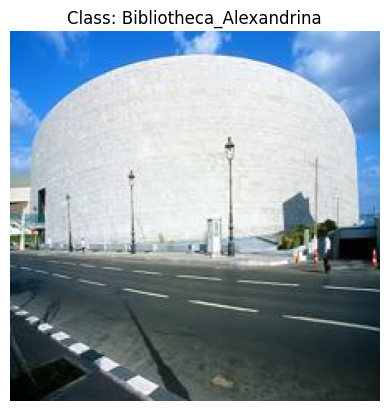

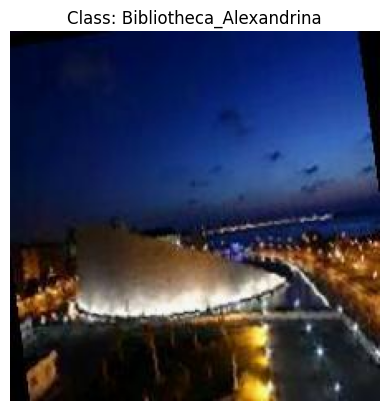

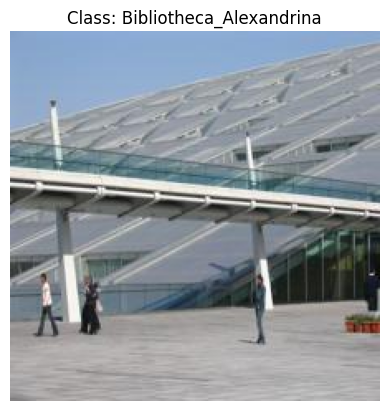

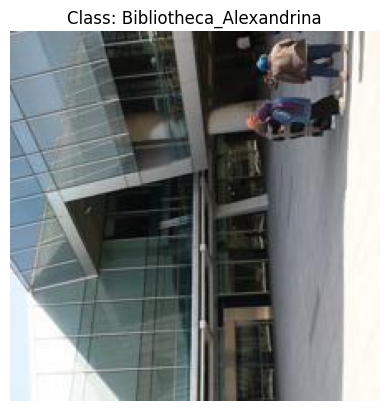

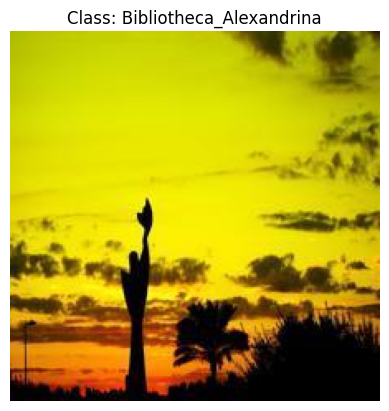

In [ ]:
import matplotlib.pyplot as plt

def display_images_of_class(image_paths, labels, class_name, class_to_idx, num_images=):
    class_index = class_to_idx[class_name]
    count = 0

    for path, label in zip(image_paths, labels):
        if label == class_index:
            img = load_img(path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0

            plt.imshow(img_array)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
            plt.show()

            count += 1
            if count >= num_images:
                break

# Example usage
display_images_of_class(image_paths, labels, 'Muizz_Street', class_to_idx)

In [ ]:
import os

dataset_path = "unzipped_data/cleaned_data"

classes = os.listdir(dataset_path)

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        print(f"Class: {class_name}, Number of images: {num_images}")

Class: Hanging_Church_(Cairo), Number of images: 100
Class: Ben_Ezra_Synagogue, Number of images: 100
Class: Temple_of_Khonsu_in_Karnak, Number of images: 100
Class: Giza_pyramid_complex, Number of images: 100
Class: Wadi_Degla, Number of images: 100
Class: Bab_Zuwayla, Number of images: 100
Class: Pyramid_of_Amenemhat_III_in_Hawara, Number of images: 100
Class: Temple_of_Isis_in_Philae, Number of images: 100
Class: 45_Hapi_The_Scribe, Number of images: 100
Class: amenhotep iii and tiye, Number of images: 100
Class: 48_Stela_of_King_Qaa, Number of images: 100
Class: Na'ama_Bay, Number of images: 100
Class: Esna_Temple, Number of images: 100
Class: Saint_George_Church_in_Coptic_Cairo, Number of images: 100
Class: Great Hypostyle Hall of Karnak, Number of images: 100
Class: Abu_el-Abbas_el-Mursi_Mosque, Number of images: 100
Class: Tomb_of_Unknown_Soldier_in_Cairo, Number of images: 100
Class: Monastery_of_Saint_Bishoy, Number of images: 100
Class: 25_Mahalawi_water_ewers, Number of imag

# **start to create the second model after error analysis**
 **(in different notebook)**